# Libraries

In [6]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import DBSCAN

In [ ]:
# change the paths for each according to your own environment (please change path accordingly)
sample_folder = r"C:\Users\kaith\OneDrive\Documents\GitHub\Project-Echo\src\Prototypes\engine\Transfer Learning Models\project-echo-data-bucket-3\Acanthiza chrysorrhoa"

# Extracting Preprocessing

C:\Users\kaith\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score (DBSCAN): 0.5880
Davies-Bouldin Score (DBSCAN): 1.2572


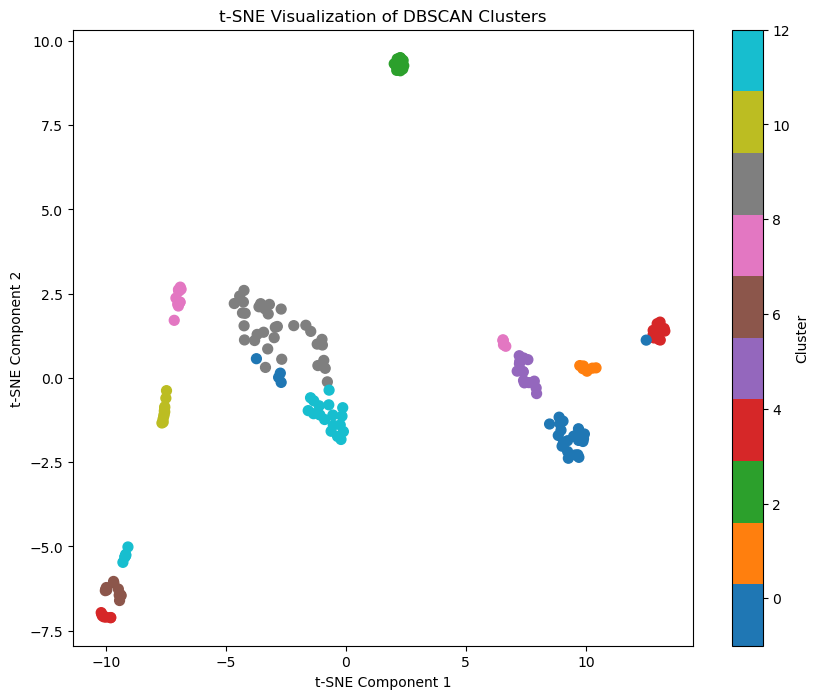

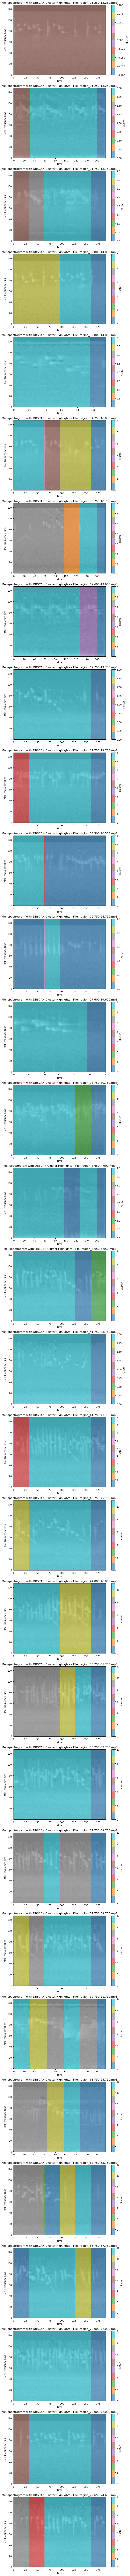

In [5]:
# Path to the directory containing .mp3 files
audio_folder = sample_folder

# times steps for each mel-spectrogram segment (allowing partitioning into smaller chucks for easier analysis)
# could require some tuning (higher the better but requires more computation)
SEGMENT_SIZE = 32  

# Function to extract comprehensive features from an audio file
def extract_features(y, sr, segment_size=SEGMENT_SIZE):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    features = []
    for start in range(0, S_dB.shape[1], segment_size):
        segment = S_dB[:, start:start + segment_size]
        if segment.shape[1] < segment_size:  # Padding the last segment if necessary
            padding = segment_size - segment.shape[1]
            segment = np.pad(segment, ((0, 0), (0, padding)), mode='constant')
        
        # Flatten and concatenate additional features
        segment_features = np.hstack([
            segment.flatten(),
            np.mean(mfccs[:, start:start + segment_size], axis=1),
            np.mean(chroma[:, start:start + segment_size], axis=1),
            np.mean(spectral_contrast[:, start:start + segment_size], axis=1)
        ])
        features.append(segment_features)
    
    return S_dB, np.array(features)

# Load and process all audio files
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3')]
features_list = []
labels_list = []
spectrograms = []

for file in audio_files:
    file_path = os.path.join(audio_folder, file)
    
    # Load the original audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract features and segment them
    S_dB, features = extract_features(y, sr)
    spectrograms.append(S_dB)
    features_list.extend(features)
    labels_list.extend([file] * len(features))

# Convert the list of features to a NumPy array
features_array = np.array(features_list)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=10, random_state=42)  # Reduce to 10 dimensions
features_umap = umap_model.fit_transform(features_scaled)

# Use DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters based on your data
dbscan_clusters = dbscan.fit_predict(features_umap)

# Evaluate clustering with Silhouette Score and Davies-Bouldin Score
silhouette_avg_dbscan = silhouette_score(features_umap, dbscan_clusters)
db_score = davies_bouldin_score(features_umap, dbscan_clusters)

print(f'Silhouette Score (DBSCAN): {silhouette_avg_dbscan:.4f}')
print(f'Davies-Bouldin Score (DBSCAN): {db_score:.4f}')

# applying t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
features_tsne_dbscan = tsne.fit_transform(features_umap)

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne_dbscan[:, 0], features_tsne_dbscan[:, 1], c=dbscan_clusters, cmap='tab10', s=50)
plt.colorbar(label='Cluster')
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Define a color map for the clusters
cmap = plt.get_cmap('tab10')

# Plot each spectrogram with highlighted clusters
plt.figure(figsize=(15, 5 * len(spectrograms)))

for i, S_dB in enumerate(spectrograms):
    plt.subplot(len(spectrograms), 2, 2 + 2 * i)
    
    # Initialize an overlay with the same shape as the spectrogram
    cluster_overlay = np.zeros_like(S_dB)
    
    num_segments = S_dB.shape[1] // SEGMENT_SIZE
    for j in range(num_segments):
        start = j * SEGMENT_SIZE
        end = start + SEGMENT_SIZE
        cluster_label = dbscan_clusters[i * num_segments + j]
        
        # Use the color map to assign a color to each cluster label
        cluster_overlay[:, start:end] = cluster_label
    
    # Plot the original spectrogram
    plt.imshow(S_dB, aspect='auto', origin='lower', cmap='gray', alpha=0.5)
    
    # Overlay the clusters with transparency
    plt.imshow(cluster_overlay, aspect='auto', origin='lower', cmap=cmap, alpha=0.6)
    
    plt.colorbar(label='Cluster')
    plt.title(f'Mel-spectrogram with DBSCAN Cluster Highlights - File name: {labels_list[i * num_segments]}')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency Bins')

plt.tight_layout()
plt.show()
